This is the notebook dedicated to running our models

Gather the dataset and imports

In [1]:
import sys
import os
import torch
import torch.optim as optim
import torch.nn as nn
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data.data_preprocessing import MRIDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pickle
from sklearn.model_selection import train_test_split



# Applying random transformations to vary data
transformations = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip()
])



# Data preloaded from pickle file
data_path = os.path.abspath(os.path.join("..", "data", "archive", "brain_tumor_mri", "new_dataset", "training_data.pickle"))
with open(data_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Unpacking the data into the images and their corresponding labels
images, labels = zip(*loaded_data)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels
)

model_type = "inception"

training_dataset = MRIDataset(train_images, train_labels, transformations, model_type=model_type)
testing_dataset = MRIDataset(test_images, test_labels, None, model_type=model_type)

# Two separate loaders for training and testing
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=32, shuffle=False)

# Debug comment out later
for sample_image, sample_label in train_loader:
    print(f"Image shape: {sample_image.shape}")
    print(f"Label: {sample_label}")
    break


Image shape: torch.Size([32, 3, 299, 299])
Label: tensor([2, 0, 1, 0, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 1, 2,
        1, 2, 0, 0, 1, 2, 1, 1])


Run the 3D CNN model

In [4]:
from models.CNN_3D.model import CNN_3D
from models.CNN_3D.train import Trainer

# Set up the model, criterion, and optimizer
model = CNN_3D(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Initialize the Trainer class
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=testing_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
)

trainer.train()

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

Run the ResNet model

In [ ]:
from models.ResNet.model import ResNet
from models.ResNet.train import train

model = ResNet()

Run the Inception model

Batch number 0, Loss: 4.4818339347839355
Batch number 1, Loss: 4.4205641746521
Batch number 2, Loss: 4.218698501586914
Batch number 3, Loss: 4.186707019805908
Batch number 4, Loss: 4.149515151977539
Batch number 5, Loss: 3.8463058471679688
Batch number 6, Loss: 3.913248062133789
Batch number 7, Loss: 3.7118351459503174
Batch number 8, Loss: 3.492187738418579
Batch number 9, Loss: 3.506296157836914
Batch number 10, Loss: 3.2240371704101562
Batch number 11, Loss: 3.44395112991333
Batch number 12, Loss: 3.1586601734161377
Batch number 13, Loss: 3.5170955657958984
Batch number 14, Loss: 2.631948947906494
Batch number 15, Loss: 2.7847180366516113
Batch number 16, Loss: 2.196122884750366
Batch number 17, Loss: 2.5176212787628174
Batch number 18, Loss: 3.295891523361206
Batch number 19, Loss: 2.8683383464813232
Batch number 20, Loss: 2.025784969329834
Batch number 21, Loss: 2.3010191917419434
Batch number 22, Loss: 2.0370705127716064
Batch number 23, Loss: 1.9722223281860352
Batch number 24, 

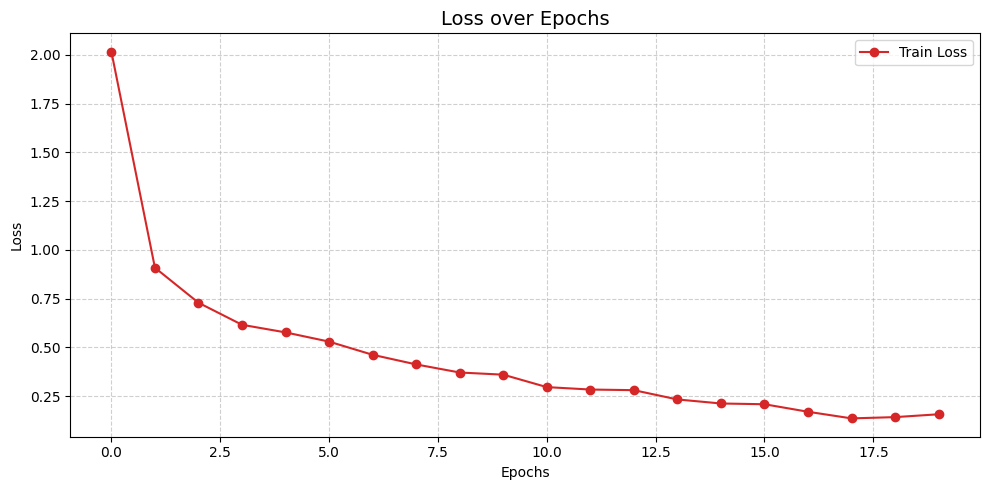

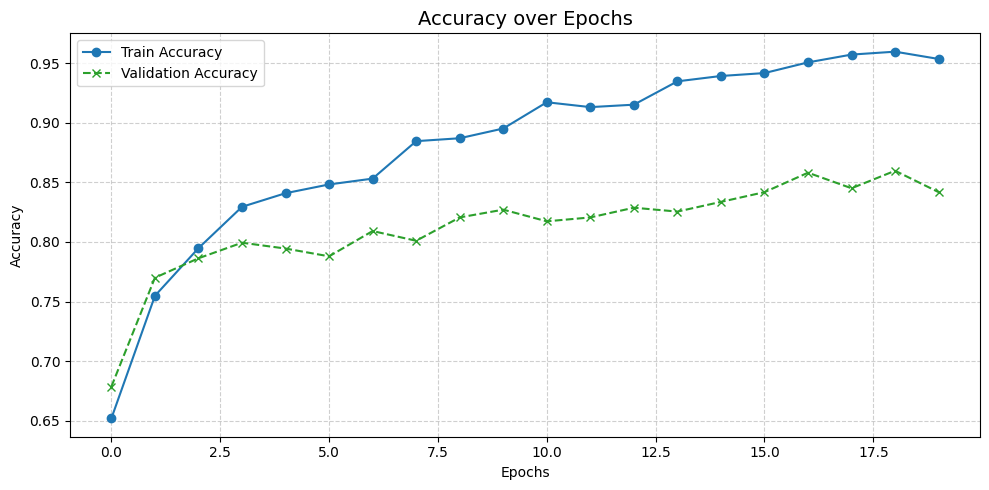

In [2]:
from models.Inception.model import Inception
from models.Inception.train import Trainer

# Set up the model, criterion, and optimizer
model = Inception(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8)

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Initialize the Trainer class
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=testing_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    aux_loss_weight=0.4
)

trainer.train()

Visualize Models

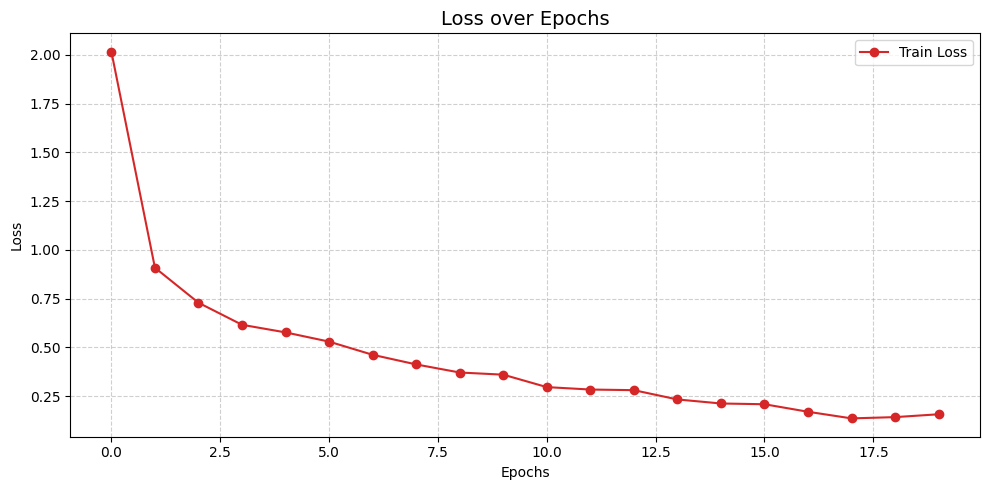

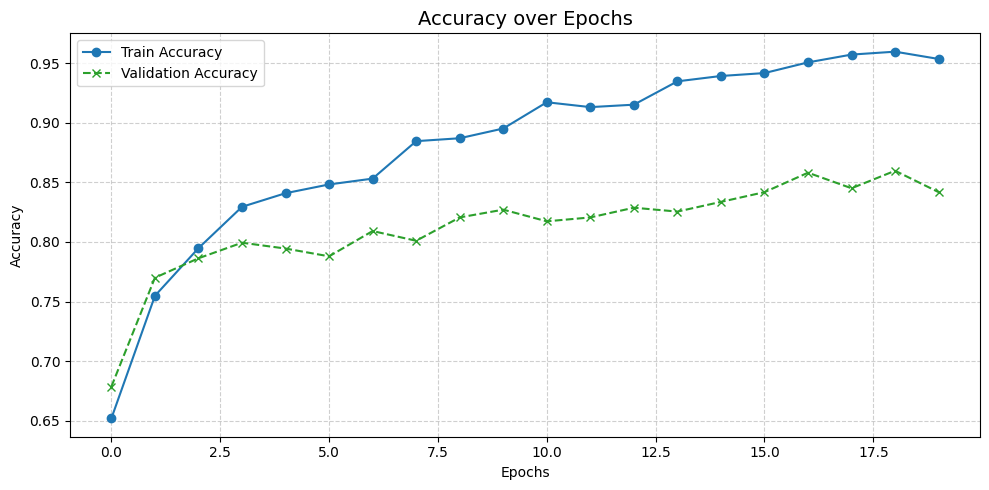

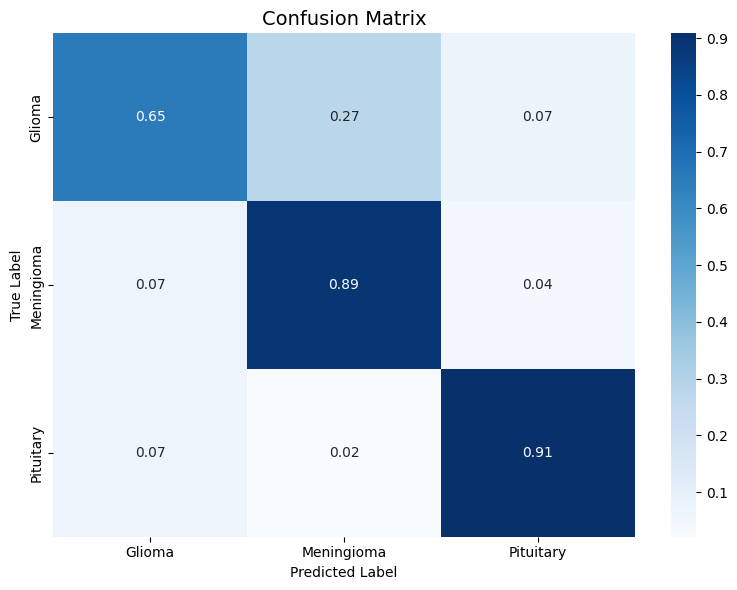

ValueError: Number of classes, 4, does not match size of target_names, 3. Try specifying the labels parameter

In [4]:
# Plot training curves
trainer.visualizer.plot_loss()
trainer.visualizer.plot_accuracy()

# Re-evaluate model and retrieve predictions
val_accuracy, y_true, y_pred = trainer.evaluate(return_preds=True)

# Visualize confusion matrix and classification report
trainer.visualizer.evaluation_summary(y_true, y_pred)

# Save all plots
trainer.visualizer.save_plots("results/figures/")